##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [19]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Generate Artificial Faces with CelebA Progressive GAN Model


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/progan-128/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This Colab demonstrates use of a TF Hub module based on a generative adversarial network (GAN). The module maps from N-dimensional vectors, called latent space, to RGB images.

Two examples are provided:
* **Mapping** from latent space to images, and
* Given a target image, **using gradient descent to find** a latent vector that generates an image similar to the target image.

## Optional prerequisites

* Familiarity with [low level Tensorflow concepts](https://www.tensorflow.org/guide/eager).
* [Generative Adversarial Network](https://en.wikipedia.org/wiki/Generative_adversarial_network) on Wikipedia.
* Paper on Progressive GANs: [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196).

### More models
[Here](https://tfhub.dev/s?module-type=image-generator) you can find all models currently hosted on [tfhub.dev](https://tfhub.dev/) that can generate images.

## Setup

In [20]:
# Install imageio for creating animations.
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-s7cplmqn
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-s7cplmqn
  Resolved https://github.com/tensorflow/docs to commit 4a634a2916fdb759ab3b61ae94a3dcc4f1658e73
  Preparing metadata (setup.py) ... done


In [21]:
#@title Imports and function definitions
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1.
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

## Latent space interpolation

### Random vectors

Latent space interpolation between two randomly initialized vectors. We will use a TF Hub module [progan-128](https://tfhub.dev/google/progan-128/1) that contains a pre-trained Progressive GAN.

In [22]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

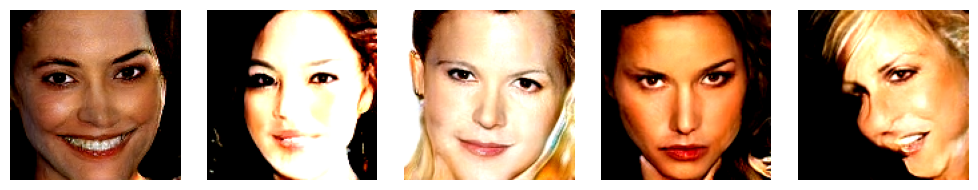

In [23]:
def generate_multiple_faces(num_faces=10):
  vectors = tf.random.normal([num_faces, latent_dim])
  images = progan(vectors)['default']
  return images

def show_images(images, cols=5):
  images = tf.image.convert_image_dtype(images, tf.uint8).numpy()
  rows = (len(images) + cols - 1) // cols
  plt.figure(figsize=(cols * 2, rows * 2))
  for i, img in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

generated_images = generate_multiple_faces(num_faces=5)
show_images(generated_images, cols=5)



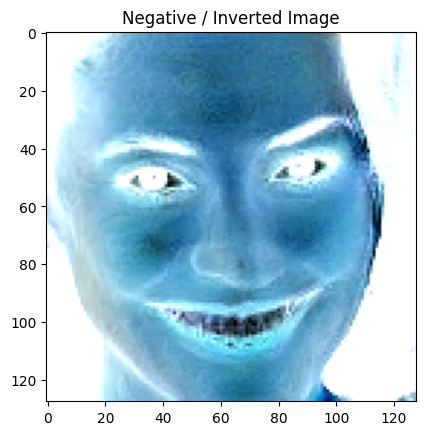

In [35]:
import matplotlib.pyplot as plt

img0 = generated_images[0]
img0_uint8 = tf.image.convert_image_dtype(img0, tf.uint8).numpy()

plt.imshow(img0_uint8)
img0_neg = 255 - img0_uint8
plt.imshow(img0_neg)
plt.title("Negative / Inverted Image")
plt.show()


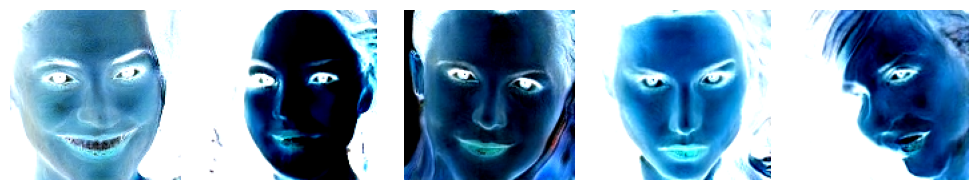

In [39]:
def show_images_np(images, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 2, rows * 2))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Convert and invert images (uint8 numpy arrays)
negative_faces = [255 - tf.image.convert_image_dtype(img, tf.uint8).numpy() for img in generated_images]

# Show all negative faces using new show_images function
show_images_np(negative_faces, cols=5)

